In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

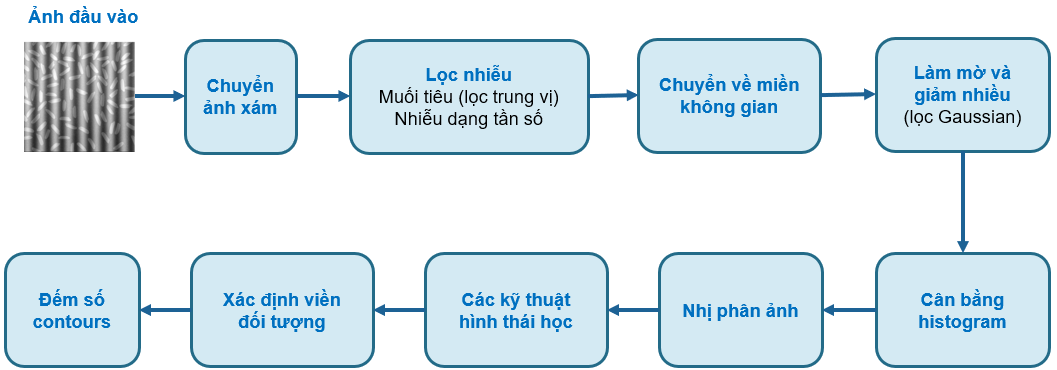

In [2]:
def show2image(image1, image2, cmap1, cmap2):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image1, 'gray' if cmap1 else None)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, 'gray' if cmap2 else None)
    plt.axis('off')

    # Hiển thị
    plt.show()

In [3]:
def gray(img_ori):
    return cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)

In [4]:
img_ori1 = cv2.imread('./data/rice1.png')
img_ori2 = cv2.imread('./data/rice2.png')
img_ori3 = cv2.imread('./data/rice3.png')
img_ori4 = cv2.imread('./data/rice4.png')
img_gray1 = gray(img_ori1)
img_gray2 = gray(img_ori2)
img_gray3 = gray(img_ori3)
img_gray4 = gray(img_ori4)

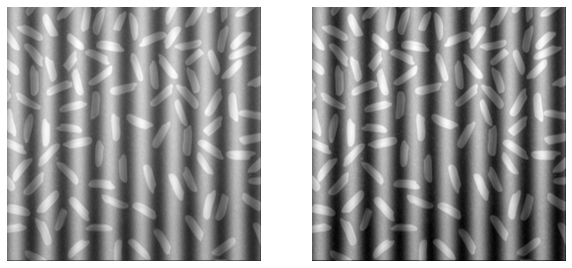

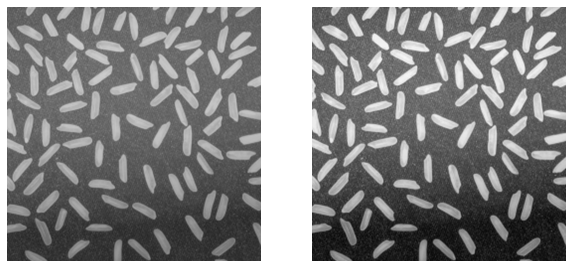

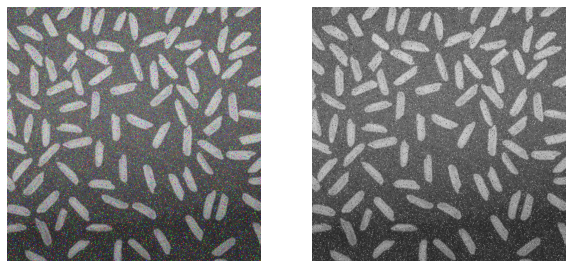

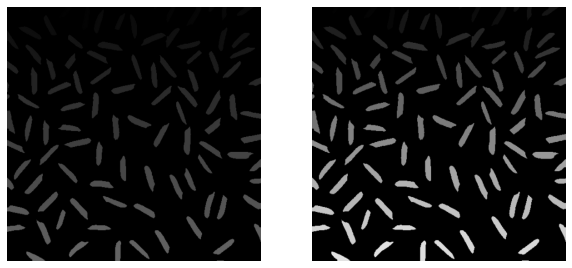

In [5]:
show2image(img_ori1, img_gray1, False, True)
show2image(img_ori2, img_gray2, False, True)
show2image(img_ori3, img_gray3, False, True)
show2image(img_ori4, img_gray4, False, True)

### Lọc nhiều

In [6]:
def medianFilter(image):
    return cv2.medianBlur(image,5)

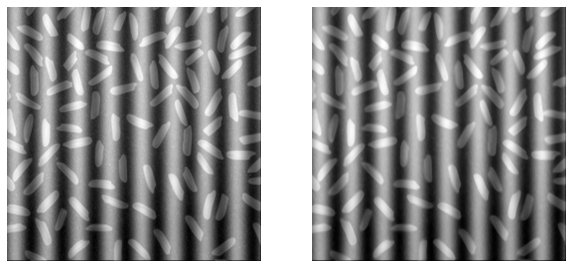

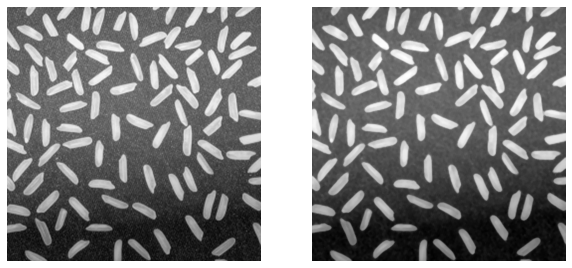

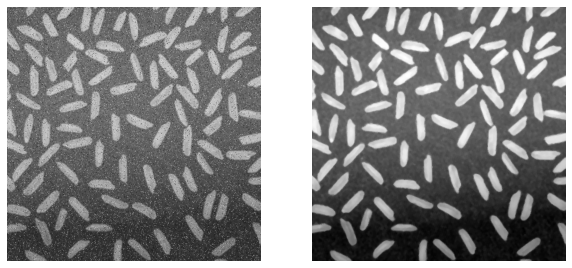

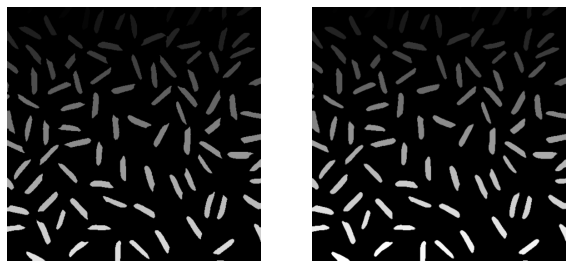

In [7]:
img_median1 = medianFilter(img_gray1)
img_median2 = medianFilter(img_gray2)
img_median3 = medianFilter(img_gray3)
img_median4 = medianFilter(img_gray4)
show2image(img_gray1, img_median1, True, True)
show2image(img_gray2, img_median2, True, True)
show2image(img_gray3, img_median3, True, True)
show2image(img_gray4, img_median4, True, True)

In [8]:
img_median1.shape

(461, 461)

In [9]:
def fourier_transform(image):
    # Chuyển ảnh từ miền không gian sang miền tần số bằng FFT
    f = np.fft.fft2(image)
    center_shift = np.fft.fftshift(f)

    # Tính độ lớn của phổ Fourier (Fourier Spectrum)
    magnitude_spectrum = 30 * np.log(np.abs(center_shift))
    return center_shift, magnitude_spectrum

def inverse_FFT(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    # inverse furier
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back).astype(np.uint8)
    return img_back

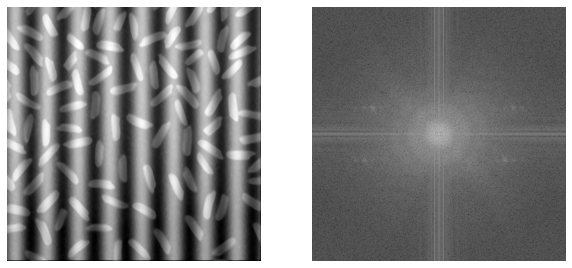

In [10]:
# Hiện tượng ringing problem
center_shift, magnitude_spectrum = fourier_transform(img_median1)
show2image(img_median1, magnitude_spectrum, True, True)

In [11]:
# img_blurred1 = cv2.GaussianBlur(img_median1, (5, 5), 0)

In [12]:
# show2image(img_median1, img_blurred1, True, True)

Low/high-pass filtering

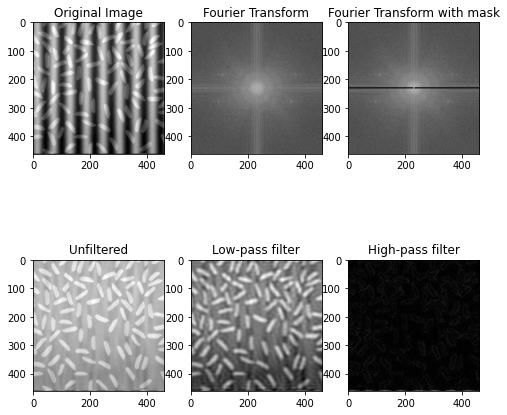

In [13]:
def computeIdealFiltering(D, Do, mode=0):
    """Computes Ideal Filtering based on the cut off frequency (Do).
    If mode=0, it compute Lowpass Filtering otherwise Highpass filtering    
    """
    H = np.zeros_like(D)
    if mode==0:
        H = (D<=Do).astype(int)
    else:
        H = (D>Do).astype(int)
    return H

def constructDuv(N):
    """Constructs the frequency matrix, D(u,v), of size NxN"""
    u = np.arange(N)
    v = np.arange(N)

    idx = np.where(u>N/2)[0]
    u[idx] = u[idx] - N
    idy = np.where(v>N/2)[0]
    v[idy] = v[idx] - N

    [V,U]= np.meshgrid(v,u)
    D = np.sqrt(U**2 + V**2)
    
    return D

def computeIdealFilters(F, D, Do):
    #Compute Ideal Lowpass Filter (ILPF)
    H_low = computeIdealFiltering(D, Do, 0)
    filtered_high = H_low * F

    #Compute Ideal Highpass Filter (IHPF)
    H_high = computeIdealFiltering(D, Do, 1)

    #Compute the filtered image (result in space domain)
    filtered_low = H_high * F 
    return filtered_low, filtered_high

rows, cols = img_median1.shape
crow, ccol = rows // 2, cols // 2

center_shift[crow - 2:crow + 2, 0:ccol - 2] = 1
center_shift[crow - 2:crow + 2, ccol + 2:] = 1

Do = 300
D = constructDuv(img_median1.shape[0])
filtered_low, filtered_high = computeIdealFilters(center_shift, D, Do)

denoised_image = inverse_FFT(center_shift)

denoised_image_blpf = inverse_FFT(filtered_low)

denoised_image_bhpf = inverse_FFT(filtered_high)

fourier_noisy_noise_removed = 30 * np.log(np.abs(center_shift))

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2, 3, 1)
ax1.title.set_text("Original Image")
ax1.imshow(img_median1, cmap='gray')
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.title.set_text("Fourier Transform")
ax3 = fig.add_subplot(2, 3, 3)
ax3.imshow(fourier_noisy_noise_removed, cmap='gray')
ax3.title.set_text("Fourier Transform with mask")
ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(denoised_image, cmap='gray')
ax4.title.set_text("Unfiltered")
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(denoised_image_blpf, cmap='gray')
ax5.title.set_text("Low-pass filter")
ax6 = fig.add_subplot(2, 3, 6)
ax6.imshow(denoised_image_bhpf, cmap='gray')
ax6.title.set_text("High-pass filter")

plt.show()

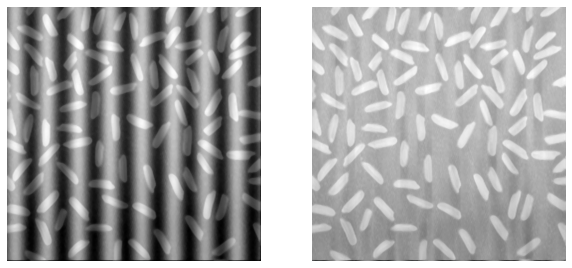

In [14]:
# Hiện tượng ringing problem
show2image(img_median1, denoised_image, True, True)

Lam blur

In [15]:
blurred = cv2.GaussianBlur(denoised_image, (5, 5), 0)

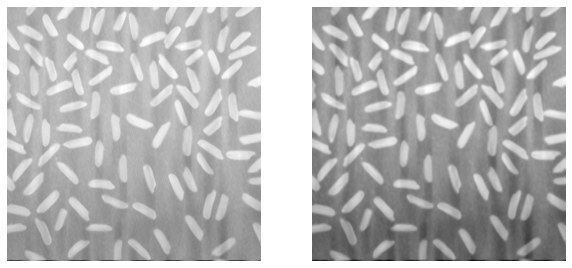

In [16]:
show2image(denoised_image, blurred, True, True)

**Cân bằng Histogram Equalization**

In [17]:
def plot_histogram(image1, image2):
    plt.figure(figsize=(10, 5))
    
    # Hiển thị ảnh gốc
    plt.subplot(1, 2, 1)
    plt.hist(image1.ravel(), bins=256, range=[0, 256])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.hist(image2.ravel(), bins=256, range=[0, 256])
    plt.axis('off')

    plt.show()

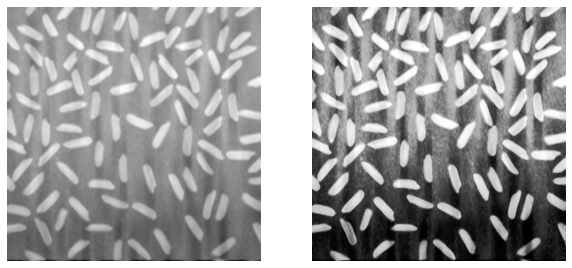

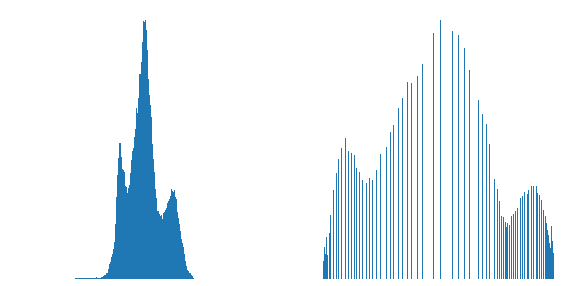

In [18]:
img_eq = cv2.equalizeHist(denoised_image)

show2image(blurred, img_eq, True, True)
plot_histogram(blurred, img_eq)

Histogram cục bộ

In [19]:
#can bang histogram cuc bo
# Tham số clipLimit càng nhỏ (>0) thì mức độ nhiễu càng ít tuy nhiên hiệu quả cân bằng sáng lại càng thấp.
h,w = blurred.shape[:]
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(int(w/50),int(h/50)))
# cl1 = clahe.apply(new_ero)
cl1 = clahe.apply(blurred)
cl1 = cv2.GaussianBlur(cl1, (5, 5), 0)

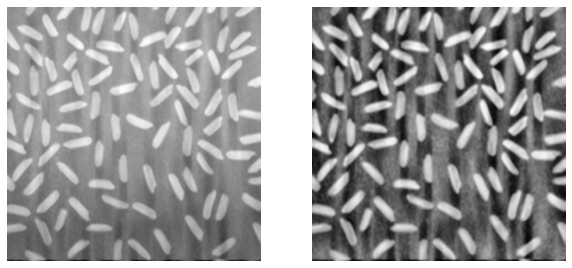

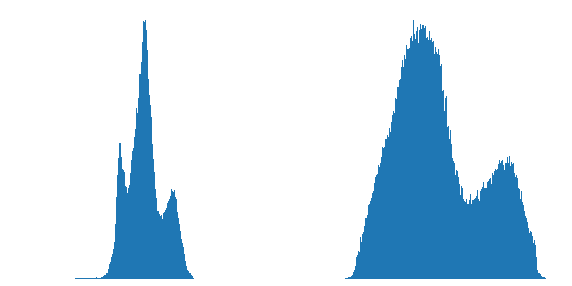

In [20]:
show2image(blurred, cl1, True, True)
plot_histogram(blurred, cl1)

In [29]:
h,w = img_gray4.shape[:]
# cl1 = clahe.apply(new_ero)
cl2 = clahe.apply(img_gray4)
cl2 = cv2.GaussianBlur(cl1, (5, 5), 0)

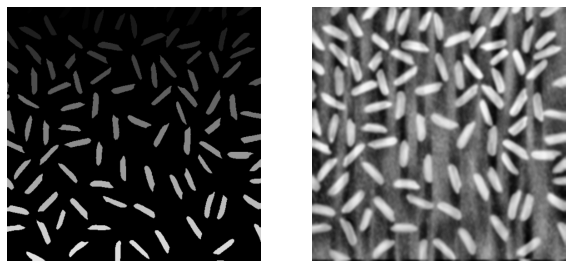

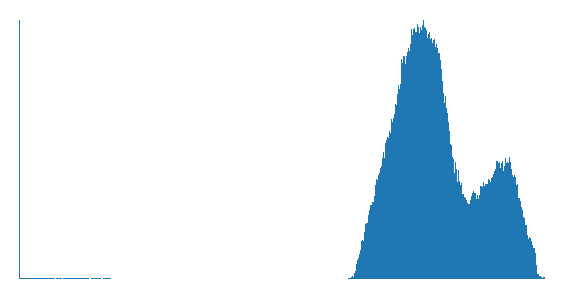

In [30]:
show2image(img_gray4, cl2, True, True)
plot_histogram(img_gray4, cl2)

In [21]:
# Hang so Gaussian 
thres1 = cv2.adaptiveThreshold(cl1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,55,-12)

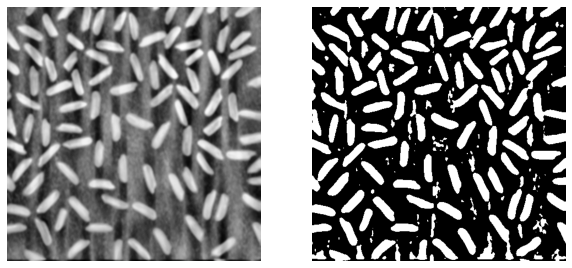

In [22]:
show2image(cl1, thres1, True, True)

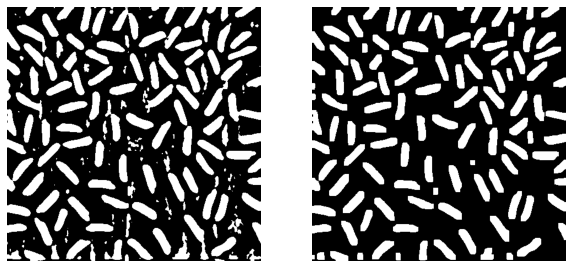

In [23]:
kernel_morphological = cv2.getStructuringElement(cv2.MORPH_RECT,(8,8)) # làm đầy các đổi tượng
thres_er = cv2.erode(thres1,kernel_morphological ,iterations = 1) #  giảm kích thước của các đối tượng trong ảnh
thres_mor_1 = cv2.dilate(thres_er,kernel_morphological,iterations = 1) # tăng kích thước của các đối tượng và làm nổi bật các ranh giới của chúng
show2image(thres1, thres_mor_1, True, True)


In [24]:
#tim contours
# RETR_EXTERNAL: trích xuất các đường viền ngoài cùng của đối tượng
# CHAIN_APPROX_SIMPLE: Phương pháp xấp xỉ đường viền
contours, hierarchy = cv2.findContours(thres_mor_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [25]:
#tim hat gao dien tich lon nhat
max_area = 0
for i, c in enumerate(contours):
    area = cv2.contourArea(c)
    max_area = max(area,max_area)
print("max are", max_area)

max are 716.5


In [26]:
img_ori = np.copy(img_ori1)
count = 0
#ve, dem va loai nhung hat gao qua nho
for i, c in enumerate(contours):
    contours_poly = cv2.approxPolyDP(c, 3, True) #  Đa giác gần đúng (polygon) với sai số = 3
    boundRect = cv2.boundingRect(contours_poly) # hình chữ nhật bao quanh đa giác xấp xỉ
    area = cv2.contourArea(c)
    if area < 0.08*max_area:
        continue
    count += 1
    cv2.rectangle(img_ori,(int(boundRect[0]), int(boundRect[1])),(int(boundRect[0]+boundRect[2]), int(boundRect[1]+boundRect[3])),(0,255,0),1)
    cv2.drawContours(img_ori,contours,i, (0,0,255), 1)
    # Viết số thứ tự bên cạnh khung hình chữ nhật
    cv2.putText(img_ori, str(count), (int(boundRect[0]), int(boundRect[1] - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

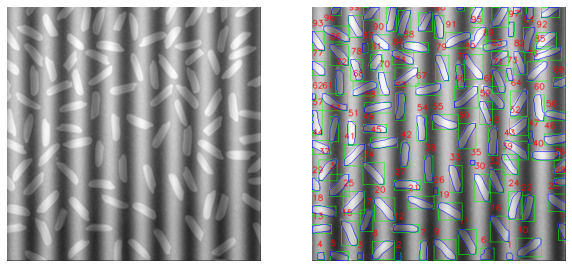

In [27]:
show2image(img_ori1, img_ori, True, False)

In [28]:
print("so hat gao",count)

so hat gao 110


In [31]:
# Tìm các connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thres_mor_1, connectivity=8) # Kết nối dựa trên 8 điểm lân cận 
output_image = np.copy(img_ori1)
# Bắt đầu từ 1 để bỏ qua background (label 0)
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    
    # Vẽ hình chữ nhật bao quanh đối tượng
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Viết số thứ tự bên cạnh khung hình chữ nhật
    cv2.putText(output_image, str(i), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

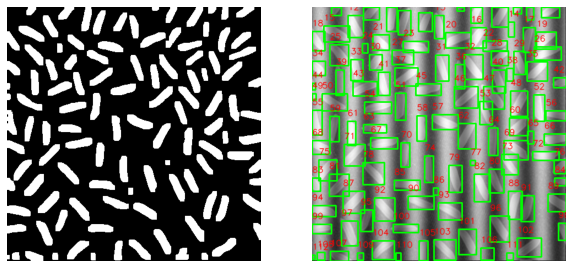

In [33]:
show2image(thres_mor_1, output_image, True, False)